
# Project: Investigate Medical Appointment No Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The analyzed dataset, called noshowappointments-kagglev2-may-2016, is a record of more than 100k medical appointments. These appointements resulted by the patient showing-up or not. This no-show status is the main response (or dependant) variable we want to analyze. Ultimately, we would like to be able to predict whether a patient is likely to show-up or not. 

The other columns of the dataset are either:
- patient characteristics: ID, gender, age, known diseases (hypertension, diabete, alcoholism), level (or number) of handicap, welfare recipient.
- appointment characteristics: ID, date the appointment was set-up, date of the appointment, neighbourhood of the hospital where the appointment takes place, SMS received. This last variable was understood as a boolean with value 1 when a summary SMS with details of the appointment was sent to the patient once the appointment is scheduled. 

Here is the list of the questions we would like to explore in this report:
- what is the 'magnitude' of the no-show problem (in terms of appointments and in terms of patients)?
- what are the main features of the patients sample (age, gender, neighbourhood, 'serious' disease, welfare)? 
- Is the ratio of no-show significantly different for patients subsamples based on age? gender? etc. 
- Is there less no-show when a SMS has been sent?
- How showing up or not to the medical appointment can be related to the number of days in advance the appointment was made?
- Finally, to which extent the no-shows are due to the same patients? Can we say there are "serial no-shower"?


In [1]:
# import useful packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling


### General Properties

We start by reading the original csv file, and plot the 5 first lines to have a look at the variables.

In [2]:
filename = 'C:/Users/Vincent/DatasetInvestigation/noshowappointments-kagglev2-may-2016.csv'
noshow_df = pd.read_csv(filename)

noshow_df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


First we want to know the number of appointments, the number of patients and the considered time period.

In [3]:
nb_appt=len(noshow_df);
nb_patients=len(noshow_df.groupby('PatientId'))
first_appt_day=noshow_df['AppointmentDay'].min()
last_appt_day=noshow_df['AppointmentDay'].max()
# we use the split function to get only the date part of the AppointmentDay string

print('The file contains {} records of appointments from {} patients covering the period from {} to {}.' \
      .format(nb_appt,nb_patients,first_appt_day.split('T')[0],last_appt_day.split('T')[0]))

# note that we checked that ApointmentID is unique by comparing len(noshow_df) and len(noshow_df.groupby('AppointmentID')).

The file contains 110527 records of appointments from 62299 patients covering the period from 2016-04-29 to 2016-06-08.


We are dealing with a relatively short period of time (less than 2 months). 
Therefore we can neglect the change in age (if any) for the different appointments of a given patient.

Now we use the describe function to have a global vision on the quantitative variables:

In [4]:
noshow_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


This quick overview gives confirmation that the Scholarship, Hipertension, Diabetes, Alcoholism and SMS_received variables are booleans.
On the other hand, the Handcap variable has a maximum of 4, which let us assume that this is teh number of handicaps of the patient. We will check this later on in the data cleaning section.
We also directly identify at least 1 surprising datapoint in the age column, the min being -1 year. This will also be dealt with in the next section.

Now let's have a closer look at the 'Neighbourhood' column.
To display the list of neighbourhoods, we print, for instance:

In [5]:
noshow_df.groupby('Neighbourhood').mean()['Age']

Neighbourhood
AEROPORTO              53.125000
ANDORINHAS             36.106101
ANTÔNIO HONÓRIO        36.845018
ARIOVALDO FAVALESSA    32.847518
BARRO VERMELHO         45.040189
BELA VISTA             34.969061
BENTO FERREIRA         44.613054
BOA VISTA              31.243590
BONFIM                 35.179228
CARATOÍRA              37.020663
CENTRO                 42.577984
COMDUSA                36.235484
CONQUISTA              31.879859
CONSOLAÇÃO             35.843023
CRUZAMENTO             34.723176
DA PENHA               36.175462
DE LOURDES             44.954098
DO CABRAL              34.614286
DO MOSCOSO             33.728814
DO QUADRO              40.315665
ENSEADA DO SUÁ         38.178723
ESTRELINHA             37.771375
FONTE GRANDE           38.237537
FORTE SÃO JOÃO         33.129698
FRADINHOS              45.701550
GOIABEIRAS             39.602857
GRANDE VITÓRIA         37.494865
GURIGICA               30.135778
HORTO                  34.800000
ILHA DAS CAIEIRAS      33.652

There are 81 different neighbourhood names in the dataset. After a quick search on internet, it turns out that they all seem to be neighbourhoods from the same brazilian city of Vitoria, capital of the state of Espírito Santo, Brazil:
https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Vit%C3%B3ria

Finally, an overall look at the date variables ('ScheduledDay' and 'AppointmentDay') suggests that the time part of the 'AppointmentDay' variable is always zero. These dates are given as strings that we will have to handle so that to calculate the number of days between scheduling and appointment.

### Cleaning variable names

We start by changing a few column names so that to stick with the same naming conventions and correct some typos.

In [6]:
noshow_df.rename(columns = {'PatientId':'Patient_ID',
                            'AppointmentID':'Appointment_ID',
                            'ScheduledDay': 'Scheduled_day',
                            'AppointmentDay': 'Appointment_day',
                            'Hipertension': 'Hypertension',
                            'Diabetes': 'Diabete',
                            'Handcap': 'Handicap'}, inplace = True)

print(noshow_df.columns)

Index(['Patient_ID', 'Appointment_ID', 'Gender', 'Scheduled_day',
       'Appointment_day', 'Age', 'Neighbourhood', 'Scholarship',
       'Hypertension', 'Diabete', 'Alcoholism', 'Handicap', 'SMS_received',
       'No-show'],
      dtype='object')


### Checking for missing data

We want to check that there is no NaN value in the 'Gender' variable and in the columns corresponding to quantitative variables. To do so, we apply the values_count function without dropping the NaN values, if any.

In [7]:
sub_noshow_df = noshow_df[['Gender','Scholarship','Hypertension','Diabete','Alcoholism','Handicap','SMS_received','No-show']]
for col in sub_noshow_df:
    print(sub_noshow_df[col].value_counts(dropna=False))

F    71840
M    38687
Name: Gender, dtype: int64
0    99666
1    10861
Name: Scholarship, dtype: int64
0    88726
1    21801
Name: Hypertension, dtype: int64
0    102584
1      7943
Name: Diabete, dtype: int64
0    107167
1      3360
Name: Alcoholism, dtype: int64
0    108286
1      2042
2       183
3        13
4         3
Name: Handicap, dtype: int64
0    75045
1    35482
Name: SMS_received, dtype: int64
No     88208
Yes    22319
Name: No-show, dtype: int64


We see that there is no NaN value in the considered columns. 
The frequency table of the column 'Handicap' gives the confirmation that this is not a boolean variable.

### Fixing the Age variable

While having a general look at the data with describe function, we saw that the 'Age' variable has a minimum value of -1, which does not make sense.
Let's have a look at the records where 'Age' is negative

In [8]:
records_neg_age=noshow_df.loc[noshow_df['Age'] < 0]
records_neg_age

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


Only one record is found. We will check if, by any chance, we have other records for this patient, in which case we could see in another record of this patient its 'true' age.

In [9]:
records_patient_neg_age=noshow_df.loc[noshow_df['Patient_ID'] == records_neg_age['Patient_ID'].iloc[0]]
records_patient_neg_age

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


There is no other record for this patient. We decide to drop this record from the dataset.

In [10]:
noshow_df=noshow_df.drop(records_patient_neg_age.index)
noshow_df.describe()

,Patient_ID,Appointment_ID,Age,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### Creating the 'Age_group' variable

In order to be able to see if the ratio of no-show depends on the age category of the patient, we propose to create a new categorical variable 'Age_group'. 
For the age categories, we use the definition given by the World Health Organization: http://www.who.int/hiv/pub/guidelines/arv2013/intro/keyterms/en/
In order to refine a little the Adult category, we introduce the Senior category for age>=65 years.

In practice we first create a function and then applying to the 'Age' column of the dataset to create the 'Age_group' column.

In [11]:
def age_group(age):
    if age<1:
        return 'Infant'
    elif age<10:
        return 'Child'
    elif age<=19:
        return 'Adolescent'
    elif age <65:
        return 'Adult'
    else:
        return 'Senior'
    
noshow_df['Age_group']=noshow_df['Age'].apply(age_group)

noshow_df.head(5)

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show,Age_group
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Adult
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Adult
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Adult
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Adult


### Creating the 'Admin_district' variable

We saw that this dataset only contains appointments in hospitals in the brazilian city of Vitoria.
The 81 neighbourhoods were the hospitals are located are grouped into 9 administrative districts (see 
http://legado.vitoria.es.gov.br/regionais/imagens/regioes/RA_GERAL.pdf
We propose to create a new categorical variable for the administrative district. As for the age_group variable, we do so by first creating a function that associate the neighbourhood to the administrative district it belongs to, and then we apply the function to the 'Neighbourhood' column of the dataset.

In [12]:
def admin_district(neighbourhood):
    if neighbourhood in ['ILHA DO PRÍNCIPE','VILA RUBIM','SANTA CLARA', \
                         'PARQUE MOSCOSO','DO MOSCOSO','PIEDADE', \
                         'FONTE GRANDE','CENTRO']:
        return 'CENTRO'
    elif neighbourhood in ['MÁRIO CYPRESTE','DO QUADRO','CARATOÍRA','DO CABRAL', \
                          'ARIOVALDO FAVALESSA','SANTA TEREZA','SANTO ANTÔNIO', \
                          'BELA VISTA','INHANGUETÁ','ESTRELINHA','UNIVERSITÁRIO', \
                          'GRANDE VITÓRIA']:
        return 'SANTO ANTÔNIO'
    elif neighbourhood in ['FRADINHOS','CRUZAMENTO','JUCUTUQUARA','DE LOURDES', \
                          'NAZARETH','CONSOLAÇÃO','HORTO','GURIGICA','ROMÃO', \
                          'FORTE SÃO JOÃO','ILHA DE SANTA MARIA','MONTE BELO', \
                          'BENTO FERREIRA','JESUS DE NAZARETH']:
        return 'JUCUTUQUARA'
    elif neighbourhood in ['JOANA D´ARC','TABUAZEIRO','MARUÍPE','SÃO CRISTÓVÃO', \
                          'SANTA MARTHA','ANDORINHAS','SANTA CECÍLIA','SANTOS DUMONT', \
                          'BONFIM','DA PENHA','ITARARÉ','SÃO BENEDITO']:
        return 'MARUÍPE'
    elif neighbourhood in ['SANTA LUÍZA','BARRO VERMELHO','SANTA LÚCIA', \
                          'PRAIA DO CANTO','ILHA DO FRADE','SANTA HELENA', \
                          'PRAIA DO SUÁ','ENSEADA DO SUÁ','ILHA DO BOI']:
        return 'PRAIA DO CANTO'
    elif neighbourhood in ['GOIABEIRAS','ANTÔNIO HONÓRIO','SEGURANÇA DO LAR', \
                          'SOLON BORGES','MARIA ORTIZ','JABOUR','AEROPORTO']:
        return 'GOIABEIRAS'
    elif neighbourhood in ['SÃO PEDRO','COMDUSA','SANTOS REIS','SÃO JOSÉ', \
                          'ILHA DAS CAIEIRAS','SANTO ANDRÉ','REDENÇÃO', \
                          'CONQUISTA','NOVA PALESTINA','RESISTÊNCIA']:
        return 'SÃO PEDRO'
    elif neighbourhood in ['JARDIM CAMBURI','PARQUE INDUSTRIAL']:
        return 'JARDIM CAMBURI'
    elif neighbourhood in ['JARDIM DA PENHA','PONTAL DE CAMBURI','MATA DA PRAIA', \
                          'BOA VISTA','MORADA DE CAMBURI','REPÚBLICA']:
        return 'JARDIM DA PENHA'
    else:
        return 'UNKNOWN'

noshow_df['Admin_district']=noshow_df['Neighbourhood'].apply(admin_district)

noshow_df['Admin_district'].value_counts()

MARUÍPE            25357
SÃO PEDRO          18021
JUCUTUQUARA        16882
SANTO ANTÔNIO      13430
GOIABEIRAS          9907
CENTRO              9306
JARDIM CAMBURI      7718
JARDIM DA PENHA     5833
PRAIA DO CANTO      4070
UNKNOWN                2
Name: Admin_district, dtype: int64

We see that there are 2 records for which the administrative district has not been assigned.
Let's have a look at them:

In [13]:
noshow_df[noshow_df['Admin_district']=='UNKNOWN']

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show,Age_group,Admin_district
48754,5.349869e+11,5583947,F,2016-04-14T12:25:43Z,2016-05-13T00:00:00Z,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,Yes,Adult,UNKNOWN
48765,7.256430e+12,5583948,F,2016-04-14T12:26:13Z,2016-05-13T00:00:00Z,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,Yes,Adult,UNKNOWN


It turns out that these 2 records correspond to the neighbourhood of 'ILHAS OCEÂNICAS DE TRINDADE', which,
after quick search on internet, indeed belongs to Vitoria, although these islands are about 1150km East of Vitoria. Note, by the way, that these 2 appointments resulted in a no-show.
We decide to keep this neighbourhood as is in the UNKNOWN administrative district category.

Creating the Admin_district category and looking at the content of the UNKNOWN category also allowed to check that there was no peculiar values in the 'Neighbourhood' variable. 



### Working on date variables

The 'Scheduling_day' and 'Appointment_day' variable contains date and time in string format. 
We first create a function that:
- takes as inputs the 'Appointment_day' and 'Scheduling_day' strings (as they are), 
- extract the date part of these strings
- transform them into datenum objects
- then return the difference, in days between the appointment and the scheduling dates.

In [14]:
def nb_days(apt_str,sch_str):
    datetime_str='%Y-%m-%d' #format of the date part of the 'Scheduling_day' and 'Appointment_day' strings
    # datetime.strptime converts to datenum objects
    # .days returns the date difference in days
    return (datetime.strptime(apt_str.split('T')[0], datetime_str) - \
            datetime.strptime(sch_str.split('T')[0], datetime_str)).days  

Then we apply this function to the noshow_df dataframe, taking the 'Appointment_day' and 'Scheduling_day' columns as input. The resulting new column is named 'Nb_days_sch_apt'.

In [15]:
noshow_df['Nb_days_sch_apt'] = noshow_df.apply(lambda x: nb_days(x['Appointment_day'], x['Scheduled_day']), axis=1)

In [16]:
noshow_df.head(10)
# it looks good

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show,Age_group,Admin_district,Nb_days_sch_apt
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Adult,JARDIM DA PENHA,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Adult,JARDIM DA PENHA,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Adult,JARDIM DA PENHA,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child,JARDIM DA PENHA,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Adult,JARDIM DA PENHA,0
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No,Senior,JARDIM DA PENHA,2
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,GOIABEIRAS,2
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes,Adult,GOIABEIRAS,2
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No,Adult,MARUÍPE,0
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No,Adolescent,SÃO PEDRO,2


Let's have a quick look at the main statistics of this new variable:

In [17]:
noshow_df['Nb_days_sch_apt'].describe()

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Nb_days_sch_apt, dtype: float64

We see a negative minimum value, which does not make sense (the scheduling should be at the latest the same day as teh appointment)
We display the records where the nb of days is negative:

In [18]:
records_appt_anachronic=noshow_df[noshow_df['Nb_days_sch_apt']<0]
records_appt_anachronic

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show,Age_group,Admin_district,Nb_days_sch_apt
27033,7.839273e+12,5679978,M,2016-05-10T10:51:53Z,2016-05-09T00:00:00Z,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,Adult,SÃO PEDRO,-1
55226,7.896294e+12,5715660,F,2016-05-18T14:50:41Z,2016-05-17T00:00:00Z,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,Adolescent,SANTO ANTÔNIO,-1
64175,2.425226e+13,5664962,F,2016-05-05T13:43:58Z,2016-05-04T00:00:00Z,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,Adult,JUCUTUQUARA,-1
71533,9.982316e+14,5686628,F,2016-05-11T13:49:20Z,2016-05-05T00:00:00Z,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,Senior,SANTO ANTÔNIO,-6
72362,3.787482e+12,5655637,M,2016-05-04T06:50:57Z,2016-05-03T00:00:00Z,7,TABUAZEIRO,0,0,0,0,0,0,Yes,Child,MARUÍPE,-1


Fortunately, only 5 records are found. These 5 records most likely correspond to registering mistakes. When scheduling the appointment, the patients were inadvertingly given already passed dates... Of course, we have a no show for all these records.
We decide to drop these 5 records

In [19]:
noshow_df=noshow_df.drop(records_appt_anachronic.index)
noshow_df['Nb_days_sch_apt'].describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Nb_days_sch_apt, dtype: float64

Here again, creating the Nb_days_sch_apt variable and looking at its quick description also allowed to check the date original variables.
At that stage, we checked the original columns, cleaned them when appropriate and created new columns that will ease the coming analysis.  

<a id='eda'></a>
## Exploratory Data Analysis



### 'Magnitude' of the no-show problem
We first want to have an overall idea of the proportion of no-show in terms of appointments, but also in terms of patients. To answer this question we first compute the (updated) total number of appointments and the number of appointment resulting in a no-show. Same approach with the patients.

In [20]:
tot_num_appts=len(noshow_df.groupby('Appointment_ID'))
tot_noshows=len(noshow_df[noshow_df['No-show']=='Yes'])

print('total number of appointment records: {}'.format(tot_num_appts))
print('total number of no-shows: {}'.format(tot_noshows))
print('')

# For the number of patients, we group by Patient_ID
tot_num_patients=len(noshow_df.groupby('Patient_ID'))
tot_num_patients_atleast1noshow=len(noshow_df[noshow_df['No-show']=='Yes'].groupby('Patient_ID'))

print('total number of patients: {}'.format(tot_num_patients))
print('total number of patients with at least 1 no-show: {}'.format(tot_num_patients_atleast1noshow))

total number of appointment records: 110521
total number of no-shows: 22314

total number of patients: 62298
total number of patients with at least 1 no-show: 17661


We can now compute the corresponding percentages:

In [21]:
percentage_appointments_noshow=100*tot_noshows/tot_num_appts
print('There is {:.0f}% of no-show among the {} appointment records in the file' \
      .format(percentage_appointments_noshow,tot_num_appts))
print('')

percentage_patients_noshow=100*tot_num_patients_atleast1noshow/tot_num_patients
print('{:.0f}% of the patients are responsible for 100% of the no-shows ({} appointments).' \
      .format(percentage_patients_noshow,tot_noshows))


There is 20% of no-show among the 110521 appointment records in the file

28% of the patients are responsible for 100% of the no-shows (22314 appointments).


### Quick visualization of the patients sample

In this section, we want to have a better idea of the sample of patients.
We group by patient and only consider the columns that describe the patient. We decide to include the 'neighbourhood' variable, although it originally corresponds to the neighbourhood of the hospital where the appointment took place.  
We assume that in the short considered time frame there is no change in the "attributes" of each patient.

In [22]:
Patients_attributes=noshow_df.groupby('Patient_ID').min()[['Gender','Age','Neighbourhood','Scholarship','Hypertension', \
                                            'Diabete','Alcoholism','Handicap','Age_group','Admin_district']]

We start by looking at the age distribution, by gender, with a histogram and boxplots.

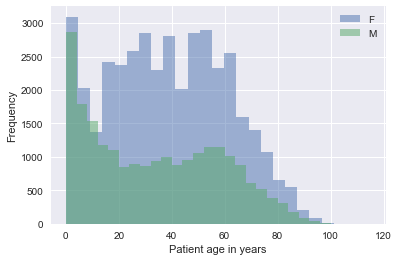

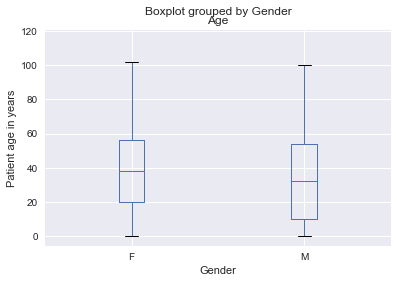

In [23]:
# histogram (bin size is about 4 years)
Patients_attributes.groupby('Gender')['Age'].plot.hist(bins=25,alpha=0.5)
plt.xlabel('Patient age in years')
plt.legend(['F','M'])

# boxplots
Patients_attributes.boxplot(column=['Age'], by='Gender')
plt.ylabel('Patient age in years');

We can see that there are much more female adult patients than male adult patients. The age distribution of the female group also show less dispersion and has a higher median value.

Now we want to illustrate the other characteristics of the patients sample using pie plots. 
As we want to label the pie  charts with the counts instead of the percentages, we create the following function:

In [24]:
total=len(Patients_attributes)

# we define this function to get the number of count from the corresponding percentage value 
def absolute_value(val):
    a  = int(np.round(val/100.*total, 0))
    return a

We present the 6 pie charts on the same figure:

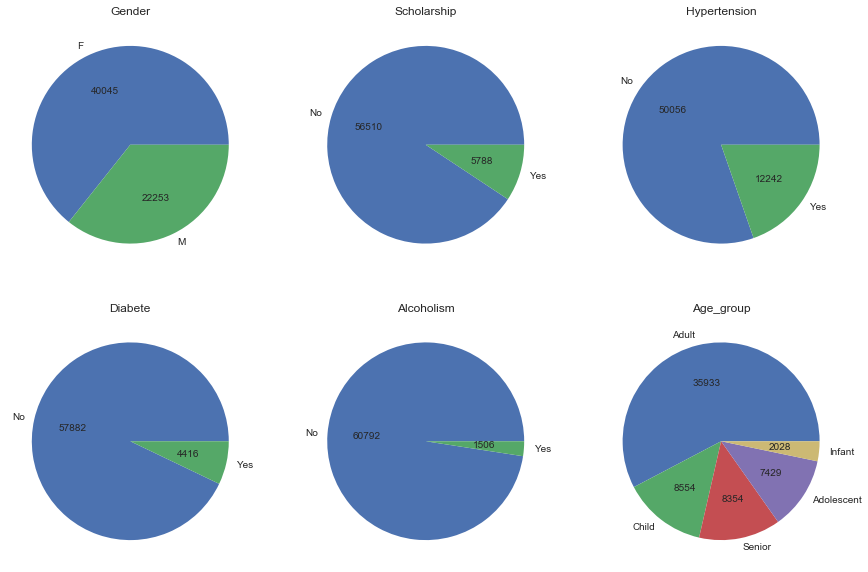

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3,)
fig.set_figheight(10)
fig.set_figwidth(15)

ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.pie(Patients_attributes['Gender'].value_counts(),autopct=absolute_value, \
        labels=Patients_attributes['Gender'].value_counts().keys())
ax0.set_title('Gender')
# we use value_counts().keys() to be able to display the legend in the proper order

ax1.pie(Patients_attributes['Scholarship'].value_counts(),autopct=absolute_value,labels=['No','Yes'])
ax1.set_title('Scholarship')

ax2.pie(Patients_attributes['Hypertension'].value_counts(),autopct=absolute_value,labels=['No','Yes'])
ax2.set_title('Hypertension')

ax3.pie(Patients_attributes['Diabete'].value_counts(),autopct=absolute_value,labels=['No','Yes'])
ax3.set_title('Diabete')

ax4.pie(Patients_attributes['Alcoholism'].value_counts(),autopct=absolute_value,labels=['No','Yes'])
ax4.set_title('Alcoholism')

ax5.pie(Patients_attributes['Age_group'].value_counts(),autopct=absolute_value, \
        labels=Patients_attributes['Age_group'].value_counts().keys())
ax5.set_title('Age_group');

Thans to these representations, we know, for instance, that than one in eleven patients are recipient of the Bolsa Familia welfare. We also see than more than a fifth of the the sample suffer from hypertension.

The handicap counts is not so well displayed in a pie chart; we prefer to display it as a table:

In [26]:
Patients_attributes['Handicap'].value_counts()

0    61165
1     1025
2       99
3        6
4        3
Name: Handicap, dtype: int64

As can be seen, only a very small portion of the patient sample (less than 2%) present at least 1 handicap. 

We now display a pie chart for the distribution over administrative districts:

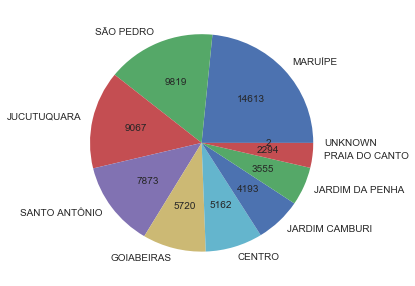

In [27]:
fig, axes = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)

axes.pie(Patients_attributes['Admin_district'].value_counts(),autopct=absolute_value, \
         labels=Patients_attributes['Admin_district'].value_counts().keys())
ax5.set_title('Admin_district');


More than half of the patients lives in the Maruipe, Sao Pedro and Jucutuquara administrative districts.

### Effect of patient attributes on no-show 

In this section we try to see whether the proportion of no-show is significantly different when we consider subgroups of the patients sample, for instance the female and male subgroups.
In order to visualize this potential difference, we display in each case the normalized contingency table and the mosaic plot. 
We automatize the process by creating a function:

In [28]:
# This function takes as input a dataframe containing a bi-state explanatory variable and 
# a bi-state response variable, and returns the contingency table and the mosaic plot 
def conting_and_mosaic(df,resp,expl,mosaic_title):
    #contingency table using crosstab. We normalize by dividing all values by the sum of values in each column
    print(pd.crosstab(df[resp],df[expl],normalize='columns'))
    #mosaic plot from statsmodels package
    mosaic(df[[expl,resp]], [expl,resp],title=mosaic_title);

#### No-show vs. gender

Gender          F         M
No-show                    
No       0.796885  0.800362
Yes      0.203115  0.199638


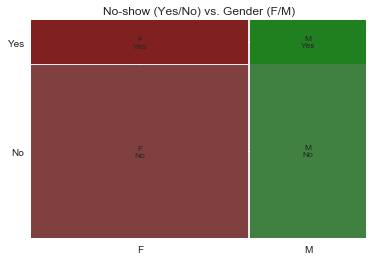

In [29]:
conting_and_mosaic(noshow_df,'No-show','Gender','No-show (Yes/No) vs. Gender (F/M)')

The mosaic plot can be interpreted as follow. 
- The proportions of the male and female subgroups is shown in the x-axis and with the color (female in red, male in green). 
- The relative proportion of no-show in each subgroup is given by the horizontal line that divides the shaded and unshaded regions. Here, these vertical lines are at about the same position, which means that the gender of teh patient has no significant effect on the patient showing-up or not at his (her) medical appointment.

#### No-show vs. Scholarship

We may think that the patients thar are recipients of the Bolsa Familia welfare are less likely not to show-up at their medical appointment. Let's use the same function as above to see how it goes:

Scholarship         0         1
No-show                        
No           0.801967  0.762637
Yes          0.198033  0.237363


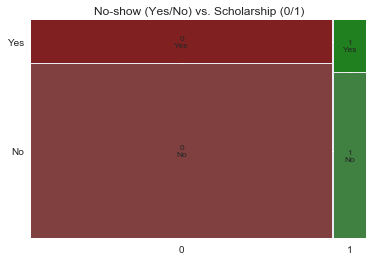

In [30]:
conting_and_mosaic(noshow_df,'No-show','Scholarship','No-show (Yes/No) vs. Scholarship (0/1)')

In fact, the proportion of patients not showing up is slightly higher in the subgroup of welfare recipients. Nevertheless, the difference is quite low (4%).  

#### No-show vs. "special care"

We could also think that the patients suffering from a "serious" disease or a handicap are less likely not to show-up as their health needs special care. 

We decide to create a new variable 'Special_care' whose value is one for the patients that either have at least a handicap or suffer from hypertension, diabete or alcoholism. 
To create this new variable, we first create a function and then apply it to the dataframe noshow_df.

In [31]:
def special_care(hyp,dia,alc,han):
    x = hyp + dia + alc + han
    if x>=1:
        return 1
    else:
        return 0

In [32]:
noshow_df['Special_care'] = noshow_df.apply(lambda x: special_care(x['Hypertension'], x['Diabete'],x['Alcoholism'], x['Handicap']), axis=1)
noshow_df.head(5)

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show,Age_group,Admin_district,Nb_days_sch_apt,Special_care
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Adult,JARDIM DA PENHA,0,1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Adult,JARDIM DA PENHA,0,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Adult,JARDIM DA PENHA,0,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child,JARDIM DA PENHA,0,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Adult,JARDIM DA PENHA,0,1


Now we display the contingency table and mosaic plot using this new variable to 'explain' the no-show. 

Special_care         0         1
No-show                         
No            0.790753  0.821507
Yes           0.209247  0.178493


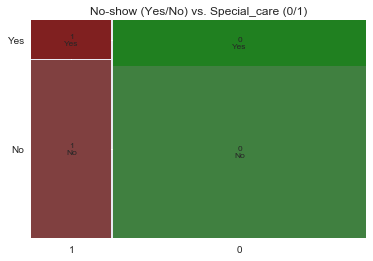

In [33]:
conting_and_mosaic(noshow_df,'No-show','Special_care','No-show (Yes/No) vs. Special_care (0/1)')

The percentage of no-show is indeed slightly lower in the subgroup that need special care, but the difference, here again, is low (3%).

#### No-show vs. age category

We could expect to see some differences in the proportion of no-show pending on the age category. Indeed, the patients in the infant category are more likely to show-up at their appointments as medical care is crucial for newborns (mandatory vaccines, standard visits to the pediatrician...). On the other hand, the patients in the adult category may be busier than the other age categories and therefore more likely not to show-up at a scheduled appointment.   

We display the normalized contingency table and the mosaic plot. 

Age_group  Adolescent     Adult    Child    Infant    Senior
No-show                                                     
No            0.74828  0.796944  0.79591  0.819441  0.845011
Yes           0.25172  0.203056  0.20409  0.180559  0.154989


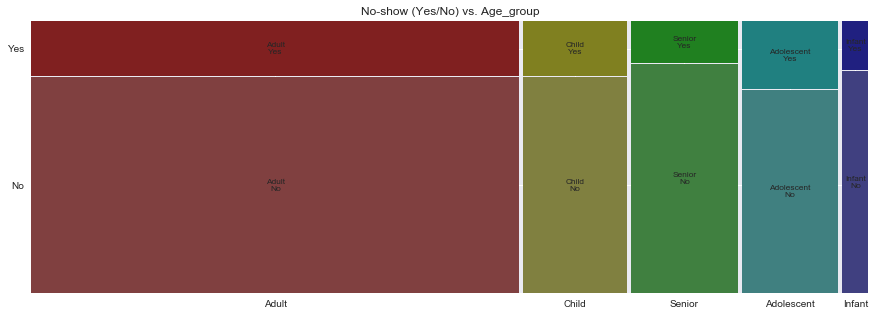

In [34]:
print(pd.crosstab(noshow_df['No-show'],noshow_df['Age_group'],normalize='columns'))

fig, axis = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
mosaic(noshow_df[['Age_group','No-show']], ['Age_group','No-show'],title='No-show (Yes/No) vs. Age_group',ax=axis);


Our guess is not completely confirmed by the analysis of the data we have. On the whole, there is:
- a lower proportion of no-show in the infant and senior age groups.
- a higher proportion of no-show in the adolescent age group.
This time the difference between the senior and adolescent groups (10%) and between the infant and adolescent groups (7%) seems significant.   

#### No-show vs. administrative district

To conclude this subsection, we wonder whether the no-show ratio is higher in some districts. This could be due, for instance, to the hospitals of a given district being in poor condition compared to the medical facilities of another district.  

To adress this point, we display once again the normalized contingency table and the mosaic plot. 

Admin_district    CENTRO  GOIABEIRAS  JARDIM CAMBURI  JARDIM DA PENHA  \
No-show                                                                 
No              0.783151    0.802665        0.810184         0.833705   
Yes             0.216849    0.197335        0.189816         0.166295   

Admin_district  JUCUTUQUARA   MARUÍPE  PRAIA DO CANTO  SANTO ANTÔNIO  \
No-show                                                                
No                  0.79083  0.790385        0.795577       0.804141   
Yes                 0.20917  0.209615        0.204423       0.195859   

Admin_district  SÃO PEDRO  UNKNOWN  
No-show                             
No               0.800444      0.0  
Yes              0.199556      1.0  


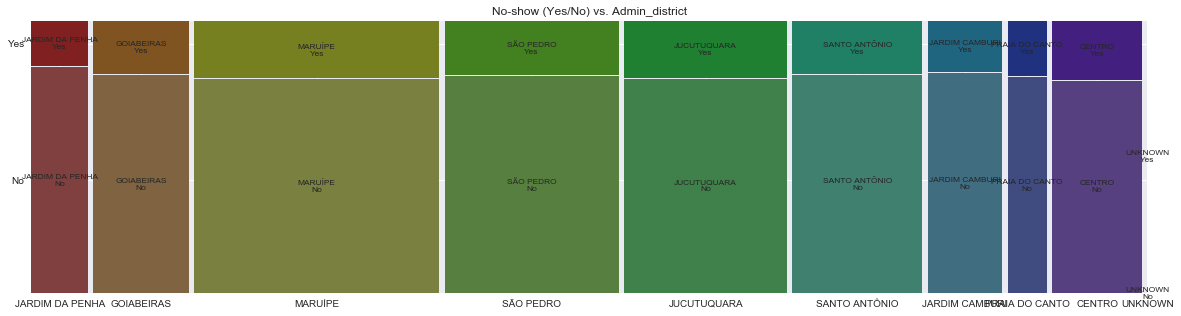

In [35]:
print(pd.crosstab(noshow_df['No-show'],noshow_df['Admin_district'],normalize='columns'))

fig, axis = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
mosaic(noshow_df[['Admin_district','No-show']], ['Admin_district','No-show'], \
       title='No-show (Yes/No) vs. Admin_district',ax=axis);

The no-show ratio of the all the administrative districts of Vitoria is between 17% to 22%. We see some differences, but on the whole the proportion of no-show is quite similar on the different districts. 

### Effect of receiving a SMS 

In this section, we want to visualize the relation between the variable SMS_received, seen as an explanatory variable, and the response variable No-show. We may expect the patients having received a SMS with the details of their medical appointment to be more likely to show-up. 

We use the same function as used in the previous sections: 

SMS_received        0         1
No-show                        
No            0.83302  0.724255
Yes           0.16698  0.275745


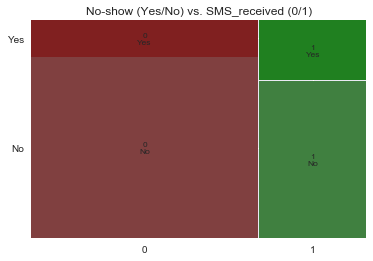

In [36]:
conting_and_mosaic(noshow_df,'No-show','SMS_received','No-show (Yes/No) vs. SMS_received (0/1)')

Surprisingly, the no-show ratio is significantly higher (difference of 11%) for the group of patients having received a SMS. In other words, analysis of this dataset does not support the idea that sending the SMS may reduce the number of no-show.

### Effect of scheduling in advance

In this section, we want to investigate the effect of the delay between scheduling and appointment dates on the fact of showing-up or not at the appointment. 

In the data wrangling section, we added a column 'Nb_days_sch_apt' to the dataset so that to be able to perform this analysis. We start by plotting the histogram of this variable:

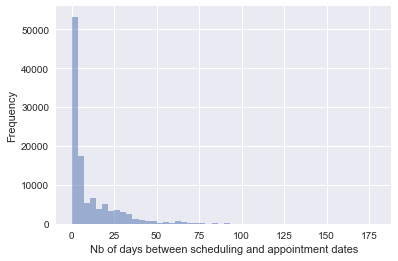

In [37]:
noshow_df['Nb_days_sch_apt'].plot.hist(bins=50,alpha=0.5)
plt.xlabel('Nb of days between scheduling and appointment dates');

This is a significantly positively skewed distribution: a large majority of the appointments were scheduled only a few days before (and even the same day as) the appointment.

We propose to create a new categorical variable from the variable 'Nb_days_sch_apt'. As already done before, we start by creating a function, then apply it to the dataframe noshow_df:  

In [38]:
def in_advance_cat(nb_days):
    if nb_days == 0:
        return 'Same_day'
    elif nb_days <=7:
        return 'within_1w'
    elif nb_days <=21:
        return 'btw_1w_and_3w'
    else:
        return 'more_than_3w'

# we create the new column using this function
noshow_df['Scheduled_in_advance']=noshow_df['Nb_days_sch_apt'].apply(in_advance_cat)

As done before i.e for studying the effect categorical variable 'Admin_district', we display the contingency table and the mosaic plot:

Scheduled_in_advance  Same_day  btw_1w_and_3w  more_than_3w  within_1w
No-show                                                               
No                    0.953529       0.687784      0.670199   0.758521
Yes                   0.046471       0.312216      0.329801   0.241479


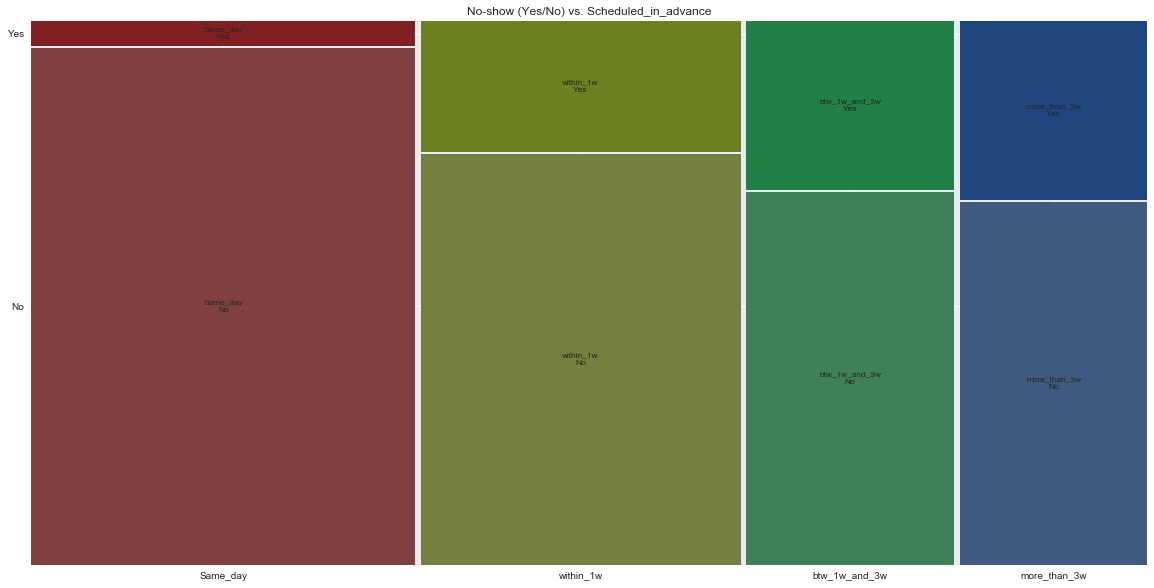

In [39]:
print(pd.crosstab(noshow_df['No-show'],noshow_df['Scheduled_in_advance'],normalize='columns'))

fig, axis = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
mosaic(noshow_df[['Scheduled_in_advance','No-show']], ['Scheduled_in_advance','No-show'], \
       title='No-show (Yes/No) vs. Scheduled_in_advance',ax=axis);

This time we see a clear pattern: the longer the period between scheduling and appointment, the higher the no-show ratio.
The proportion of no-show drops to less than 5% when we consider the patients that scheduled an appointment for the very same day. When it's urgent, you show up.
At the other end of the scale, there is almost one third of the appointments booked more than 3 weeks in advance that result in a no-show.  

### Effect of the "serial no-shower"

In this section, we want to see to which extent the no-shows are due to the same patients. Does it make sense to define a category of "serial no-shower"?  

As we will need, at some point, to sum the no-show of the patients, we first create a new boolean variable 'noshow_1-0' in the noshow_df dataframe, which is simply the column 'No-show' where Yes=1 and No=0.

In [40]:
def yes_to_1(str):
    if str == 'Yes':
        return 1
    else:
        return 0
    
noshow_df['noshow_1-0']=noshow_df['No-show'].apply(yes_to_1)

####  At least 1 no-show, at least 2 no-shows

We know already (refer to the section 'Magnitude' of the no-show problem), that 28% of the patients are responsible for 100% of the no-shows. Now we would like to calculate the proportion of no-shows due to patients responsible for at least 2 no-shows.

To do so, we create the dataframe containing only the appointments resulting in a no-show. We then group by Patient_ID and perfrom a sum over the 'noshow_1-0' variable:

In [41]:
no_show_is_yes_df=noshow_df[noshow_df['No-show']=='Yes']

no_show_sum_per_patient=no_show_is_yes_df.groupby('Patient_ID').sum()['noshow_1-0']

We then compute the total number of patients with a at least 2 no-shows, and the total number of no-shows due to patients with at least 2 no-shows.

In [42]:
tot_num_patients_atleast2noshows=len(no_show_sum_per_patient[no_show_sum_per_patient>1])
tot_no_shows_patients_atleast2noshows=sum(no_show_sum_per_patient[no_show_sum_per_patient>1])
print('total number of patients with at least 2 no-shows: {}'.format(tot_num_patients_atleast2noshows))
print('total number of no-shows due to patients with at least 2 no-shows: {}'.format(tot_no_shows_patients_atleast2noshows))

total number of patients with at least 2 no-shows: 3223
total number of no-shows due to patients with at least 2 no-shows: 7876


Finally, we compute the percentage of patients and no-shows they respectively correspond to:

In [43]:
percentage_patients_atleast2noshows=100*tot_num_patients_atleast2noshows/tot_num_patients
percentage_no_shows_patients_atleast2noshows=100*tot_no_shows_patients_atleast2noshows/tot_noshows
print('The patients with at least 2 no-shows represents {:.0f}% of the patients but are responsible for {:.0f}% of the no shows.' \
      .format(percentage_patients_atleast2noshows,percentage_no_shows_patients_atleast2noshows))

The patients with at least 2 no-shows represents 5% of the patients but are responsible for 35% of the no shows.


#### The worst of the "serial no-shower" ?

We want to have a closer look at the records of the "massive" serial no-shower. We start by looking at the maximum number of no-show from the same patient:

In [44]:
no_show_is_yes_df.groupby('Patient_ID').count()['Age'].max()

18

We see a maximum of 18 no shows in a less than 2 months time period!
Let's have a deeper look at the records of the patient(s) with 18 no-shows:

In [45]:
# we get the index with argmax
top_no_showerID=no_show_is_yes_df.groupby('Patient_ID').count()['Age'].argmax()
# we display the records
noshow_df[noshow_df['Patient_ID']==top_no_showerID]

,Patient_ID,Appointment_ID,Gender,Scheduled_day,Appointment_day,Age,Neighbourhood,Scholarship,Hypertension,Diabete,Alcoholism,Handicap,SMS_received,No-show,Age_group,Admin_district,Nb_days_sch_apt,Special_care,Scheduled_in_advance,noshow_1-0
53206,1.421987e+12,5683659,M,2016-05-11T07:44:50Z,2016-05-11T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
53218,1.421987e+12,5660212,M,2016-05-04T15:50:42Z,2016-05-04T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
53323,1.421987e+12,5660224,M,2016-05-04T15:51:21Z,2016-05-04T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
53381,1.421987e+12,5740918,M,2016-05-25T16:34:32Z,2016-05-25T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
53387,1.421987e+12,5683709,M,2016-05-11T07:47:24Z,2016-05-11T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
53400,1.421987e+12,5660301,M,2016-05-04T16:05:24Z,2016-05-04T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
53418,1.421987e+12,5660316,M,2016-05-04T16:07:01Z,2016-05-04T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
70906,1.421987e+12,5740886,M,2016-05-25T16:28:35Z,2016-05-25T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
70914,1.421987e+12,5683830,M,2016-05-11T07:55:08Z,2016-05-11T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1
70935,1.421987e+12,5660323,M,2016-05-04T16:08:03Z,2016-05-04T00:00:00Z,9,SÃO BENEDITO,0,0,0,0,1,0,Yes,Child,MARUÍPE,0,1,Same_day,1


There is only one patient with 18 no-shows. Quite surprisingly, this patient has never shown up to any appointment.
Looking at these 18 records we see that they corresponds only to 5 appointment days. We can see that with a group by Appointment_day:

In [46]:
noshow_df[noshow_df['Patient_ID']==top_no_showerID].groupby('Appointment_day')['Age'].count()

Appointment_day
2016-05-04T00:00:00Z    5
2016-05-11T00:00:00Z    3
2016-05-25T00:00:00Z    2
2016-06-01T00:00:00Z    5
2016-06-08T00:00:00Z    3
Name: Age, dtype: int64

This unexpected finding let us question the appointment scheduling system. Indeed, it looks like the system allowed scheduling several times an appointment for the same day. The patient did not receive any confirmation and thus kept on setting up appointments? Why don't we have at least one record per day with no-show=No ?

One hypothesis is that the patient never knew whether the booking process had worked and prefered to go directly to the hospital. It seems that the patient did not know how to use the appointment booking tool... 
 
The same pattern was observed for other "top" no-shower (not shown in this notebook), suggesting that there might be a number of no-show records that correspond in fact to misuses of the tool.  

#### Book to show ratio

To go further, we introduce the notion of book_to_show ratio. A book_to_show ratio of 1, means that the patient always showed up at the appointment he (she) scheduled. At the opposite side, a book_to_show ratio of 0 means that the patient never showed to his(her) scheduled appointment(s).

In [47]:
patients_book2show_series=noshow_df.groupby('Patient_ID').mean()['noshow_1-0']
patients_book2show_series=1-patients_book2show_series

We plot the histogram of this new variable: 

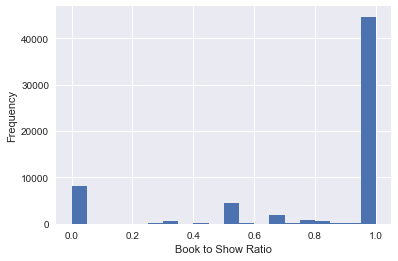

In [48]:
patients_book2show_series.plot.hist(bins=20)
plt.xlabel('Book to Show Ratio');

We can see that there are clearly 2 kinds of patients: those who always show up when they book an appointment
and those who never showed up to the appointments they booked.

To finish, we calculate the number of patients who never showed up at the appointment(s) they booked, and the portion of the patient sample they represent. 
We do the same for the patients who always showed up.

In [49]:
num_patients_book2showiszero=patients_book2show_series[patients_book2show_series == 0].count()
print('There are {} patients who never showed up at the appointment(s) they booked.'.format(num_patients_book2showiszero))
print('They corresponds to {:.0%} of the patients.'.format(num_patients_book2showiszero/tot_num_patients))
print('')

num_patients_book2showisone=patients_book2show_series[patients_book2show_series == 1].count()
print('There are {} patients who always showed up at the appointment(s) they booked.'.format(num_patients_book2showisone))
print('They corresponds to {:.0%} of the patients.'.format(num_patients_book2showisone/tot_num_patients))

There are 8145 patients who never showed up at the appointment(s) they booked.
They corresponds to 13% of the patients.

There are 44637 patients who always showed up at the appointment(s) they booked.
They corresponds to 72% of the patients.


<a id='conclusions'></a>
## Conclusions



On the whole, there is 20% of no-show among the 110521 appointment records in the file, which cover a period from 2016-04-29 to 2016-06-08.
28% of the patients are responsible for 100% of the no-shows (22314 appointments).

We first tried to explain the variable 'No-show' by different patient-related features considered as independant variables:
- The gender of the patient, the fact of being recipient of the Bolsa familia welfare, the fact of needing special care (patients suffering from hypertension, diabete, alcoholism or at least one handicap) or the administrative district did not exhibit significant effect on the no-show ratio.
- On the other hand, the adolescent age category was found to have a no-show ratio 10% above that of the senior age category.

We then investigated the effect receiving a confirmation SMS (with details of the appointment) on the no-show ratio. Surprisingly, the no-show ratio was found significantly higher (difference of 11%) for the group of patients having received a SMS.

A clear trend was then observed when studying the no-show variable versus the period between scheduling and appointment. The longer this period, the higher the no-show ratio. The proportion of no-show was found to be less than 5% for the patients making an appointment for the same day. At the other end of the scale, one third of the appointments made more than 3 weeks in advance resulted in a no-show.

Finally, it was found that the patients with at least 2 no-shows represented 5% of the patients but were responsible for 35% of the no shows. Several "serial no-showers" with more than 10 no-shows (in a less than 2 month period) were found. Nevertheless, a deeper look at the records of these patients suggested that there might be a number of no-show records corresponding in fact to misuses of the booking tool. 

A last finding was that 13% of the patients never showed up at the appointment(s) they booked, while 72% of the patients always show up (quasi bimodal distribution of the book-to-show ratio).

This analysis was performed without doing any statistical tests. The assumptions and observed trends would need to be confirmed or infirmed by dedicated statistical tests (next issue of this notebook?). 